# Intorduction to Backpropagation

An introduction to the backpropagation algorithm in Julia. This notebook uses an example equation and starts with defining a value object and what variables are needed to build our computational graph. Lastly we go backward step by step to calculate the gradients of our example equation.

It is based on Karpathy's [nn-zero-to-hero](https://github.com/karpathy/nn-zero-to-hero/tree/73c3fcc741f0ec104ca850b1fb0df90e7e8d4cde/lectures/micrograd) (with [video lecture](https://youtu.be/VMj-3S1tku0?si=0DG1mXs1EaMFEmdl)) and [Microgram.jl](https://github.com/ajloza/Micrograd.jl), which is a port of [micrograd](https://github.com/karpathy/micrograd) to julia.  

In [1]:
import Pkg;
Pkg.activate("mymicrograd");
Pkg.add("GraphViz")
Pkg.add("Plots");
Pkg.add("Revise");
using Plots 
using Revise

  Activating project at `~/Library/Mobile Documents/com~apple~CloudDocs/Projects/backprop-introduction/mymicrograd`
   Resolving package versions...
  No Changes to `~/Library/Mobile Documents/com~apple~CloudDocs/Projects/backprop-introduction/mymicrograd/Project.toml`
  No Changes to `~/Library/Mobile Documents/com~apple~CloudDocs/Projects/backprop-introduction/mymicrograd/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Library/Mobile Documents/com~apple~CloudDocs/Projects/backprop-introduction/mymicrograd/Project.toml`
  No Changes to `~/Library/Mobile Documents/com~apple~CloudDocs/Projects/backprop-introduction/mymicrograd/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Library/Mobile Documents/com~apple~CloudDocs/Projects/backprop-introduction/mymicrograd/Project.toml`
  No Changes to `~/Library/Mobile Documents/com~apple~CloudDocs/Projects/backprop-introduction/mymicrograd/Manifest.toml`


In [2]:
f_x(x) = 3*x^2 - 4*x + 5

f_x (generic function with 1 method)

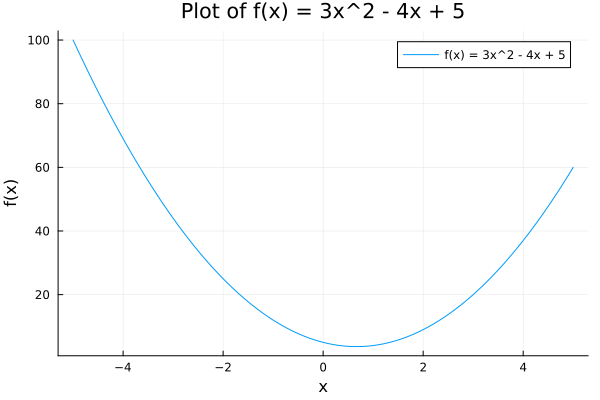

In [22]:
# array of x values fom -5 to 5
x = -5:0.1:5

# array of y values
y = f_x.(x)

# plot the function
plot(x, y, label="f(x) = 3x^2 - 4x + 5", xlabel="x", ylabel="f(x)", title="Plot of f(x) = 3x^2 - 4x + 5")

estimating the derivative of our function using finite differences:

slope = (f_x(x_s + h) - f_x(x_s)) / h = 2.999378523327323e-6
slope = (f_x(x_s + h) - f_x(x_s)) / h = 8.000003001384925


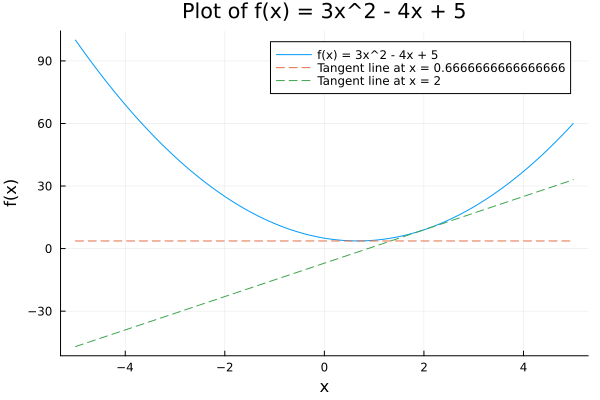

In [23]:
# plot the tangent line
h = 0.000001
x_s = 2 / 3
@show slope = (f_x(x_s + h) - f_x(x_s)) / h;
plot!(x -> slope * (x - x_s) + f_x(x_s), -5, 5, label="Tangent line at x = $x_s", linestyle=:dash)
x_s = 2
@show slope = (f_x(x_s + h) - f_x(x_s)) / h;
plot!(x -> slope * (x - x_s) + f_x(x_s), -5, 5, label="Tangent line at x = $x_s", linestyle=:dash)

# Let's use another example for building our computational graph
Let's use another function with multiple variables:

In [24]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

@show d1 = a*b + c;

d1 = a * b + c = 4.0


If we add `h` to `a` what do you expect the change in `d` to be? Is it positive or negative? 

What if you change the value of `a`. Does it influence the slope? 

You can also replace `a` with `b` or `c` and see how the slope changes.

In [25]:
b += h

-2.9999

In [26]:
@show d2 = a * b + c

# slope
@show slope = (d2 - d1) / h;

d2 = a * b + c = 4.0002
slope = (d2 - d1) / h = 2.0000000000042206


let's define a value object

> note that we will use a struct in julia

In [27]:
# main type to handle relations and operations for backprop
mutable struct Value1{T<:AbstractFloat}
    data::T
end

value(d::T) where {T} = Value1(d)

value (generic function with 1 method)

In [28]:
a = value(2.0)
a.data

2.0

Now let's define `b`and add `a` and `b` together. 

In [29]:
b = value(-3.0)
a+b

MethodError: MethodError: no method matching +(::Value1{Float64}, ::Value1{Float64})

Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...)
   @ Base operators.jl:587


In [30]:
function Base.:+(x::Value1{T}, y::Value1{T}) where {T}
    out = value(x.data + y.data)
    return out
end

In [31]:
@show a + b;

a + b = Value1{Float64}(-1.0)


In [32]:
Base.:+(x::Value1{T}, y::T) where {T} = x + Value1(y)
Base.:+(y::T, x::Value1{T}) where {T} = x + Value1(y)

# define subtraction in terms of unary minus and plus
Base.:-(x::Value1{T}, y::Value1{T}) where {T} = x + (-y)
Base.:-(x::Value1{T}, y::T) where {T} = x - Value1(y)
Base.:-(y::T, x::Value1{T}) where {T} = Value1(y) - x
Base.:-(x::Value1{T}) where {T} = x * -1.0

function Base.:*(x::Value1{T}, y::Value1{T}) where {T}
    out = Value1(x.data * y.data)
    return out
end
Base.:*(x::Value1{T}, y::T) where {T} = x * Value1(y)
Base.:*(y::T, x::Value1{T}) where {T} = x * Value1(y)

In [33]:
c = value(10.0)
@show a * b + c;

a * b + c = Value1{Float64}(4.0)


## Save Previous Values and Operations

Extending our Value struct to include the operation and previous values:

In [34]:
mutable struct Value2{T<:AbstractFloat}
    data::T
    prev::Tuple
    op::String
end

value(d::T, c=(), o="") where {T} = Value2(d, c, o)

value (generic function with 3 methods)

In [35]:
function Base.:+(x::Value2{T}, y::Value2{T}) where {T}
    out = Value2(x.data + y.data, (x, y), "+")
    return out
end
Base.:+(x::Value2{T}, y::T) where {T} = x + Value2(y)
Base.:+(y::T, x::Value2{T}) where {T} = x + Value2(y)

# define subtraction in terms of unary minus and plus
Base.:-(x::Value2{T}, y::Value2{T}) where {T} = x + (-y)
Base.:-(x::Value2{T}, y::T) where {T} = x - Value2(y)
Base.:-(y::T, x::Value2{T}) where {T} = Value2(y) - x
Base.:-(x::Value2{T}) where {T} = x * -1.0

function Base.:*(x::Value2{T}, y::Value2{T}) where {T}
    out = Value2(x.data * y.data, (x, y), "*")
    return out
end
Base.:*(x::Value2{T}, y::T) where {T} = x * Value2(y)
Base.:*(y::T, x::Value2{T}) where {T} = x * Value2(y)


In [36]:
a = value(2.0)
b = value(-3.0)
c = value(10.0)

d = a * b + c
@show d.data
@show d.prev
@show d.op;

d.data = 4.0
d.prev = (Value2{Float64}(-6.0, (Value2{Float64}(2.0, (), ""), Value2{Float64}(-3.0, (), "")), "*"), Value2{Float64}(10.0, (), ""))
d.op = "+"


# Derivatives and Gradients

## Partial Derivatives
In the lecture we have already seen the partial derivative of a function with multiple variables. We can calculate the partial derivative of a function $f(x,y)$ with respect to $x$ by treating $y$ as a constant:
$$
\frac{\partial f}{\partial x} 
$$
We can interpret this as how much $f(x,y)$ changes when $x$ changes. We can do this for all variables of $f$. Hence, we can also calculate the partial derivative of the function $f(x,y)$ with respect to $y$ by treating $x$ as a constant. 

For our example from above with the function

$$
f(x,y) = 0.5*sin(x) + cos(y)
$$ 

we would get
$$

\frac{\partial f(x,y)}{\partial x} = 0.5*cos(x)
$$
for the partial derivative with respect to $x$ and 
$$
\frac{\partial f(x,y)}{\partial y} = -sin(y)
$$
for the partial derivative with respect to $y$.

## Total Derivatives

The total derivative of a function $f(x,y)$ with respect to $x$ and $y$ is defined as:
$$
d f = \frac{\partial f}{\partial x} {d x} + \frac{\partial f}{\partial y} {d y} =  f_x {d x} + f_y {d y} 
$$

Remember, the total derivative gives us the relationship of changes in the function $f(x,y)$ when $x$ and $y$ change. Hence $d x$ and $d y$ are not variables we can calculate with: $d x \neq \Delta x$. 
We can make an approximation: 
$$
\Delta x \approx \frac{\partial f}{\partial x} {\Delta x} + \frac{\partial f}{\partial y} {\Delta y}
$$

## Gradient
The gradient of a function $f(x,y)$ is defined as:
$$
\nabla f = \begin{bmatrix}
\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}
\end{bmatrix}
$$
and we can write the total derivative as:
$$
d f = \nabla f \cdot \begin{bmatrix}
d x \\
d y
\end{bmatrix}
$$

## Adding the Gradient

Extending our Value struct to include the Gradient:

In [37]:
include("./src/display.jl")
import .DisplayGraph

In [38]:
mutable struct Value{T<:AbstractFloat}
    data::T
    grad::T
    prev::Tuple
    op::String
end

value(d::T, g::T=zero(T), c=(), o="") where {T} = Value(d, g, c, o)

value (generic function with 6 methods)

In [39]:
# --------------- ops --------------- #

function Base.:+(x::Value{T}, y::Value{T}) where {T}
    out = value(x.data + y.data, zero(T), (x, y), "+")
    return out
end
Base.:+(x::Value{T}, y::T) where {T} = x + value(y)
Base.:+(y::T, x::Value{T}) where {T} = x + value(y)

# define subtraction in terms of unary minus and plus
Base.:-(x::Value{T}, y::Value{T}) where {T} = x + (-y)
Base.:-(x::Value{T}, y::T) where {T} = x - value(y)
Base.:-(y::T, x::Value{T}) where {T} = value(y) - x
Base.:-(x::Value{T}) where {T} = x * -1.0

function Base.:*(x::Value{T}, y::Value{T}) where {T}
    out = value(x.data * y.data, zero(T), (x, y), "*")
    return out
end
Base.:*(x::Value{T}, y::T) where {T} = x * value(y)
Base.:*(y::T, x::Value{T}) where {T} = x * value(y)

In [40]:
a = value(2.0)
b = value(-3.0)
c = value(10.0)

d = a * b + c
@show d.data
@show d.prev
@show d.op;
@show d.grad;

d.data = 4.0
d.prev = (Value{Float64}(-6.0, 0.0, (Value{Float64}(2.0, 0.0, (), ""), Value{Float64}(-3.0, 0.0, (), "")), "*"), Value{Float64}(10.0, 0.0, (), ""))
d.op = "+"
d.grad = 0.0


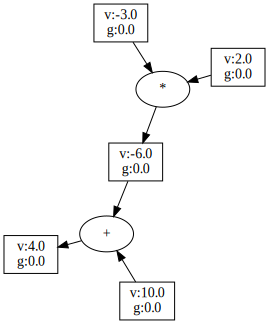

In [41]:
DisplayGraph.display_graph(d)

Now we have to fill in the gradients. Assume we have the following calculation: 
```julia
a = value(2.0)
b = value(-3.0)
c = value(10.0)
f = value(-2.0)
e = a * b
d = e + c
L = d * f
```
What if we want to know $\frac{d L}{d d}$? We know that $\frac{d L}{d d}=f$. We can also see this if we would use the finite difference approach from above. Similarly, $\frac{d L}{d f}$ will just be $d$. So we can write the first gradient of $\frac{d L}{d d}$ and $\frac{d L}{d f}$ as:


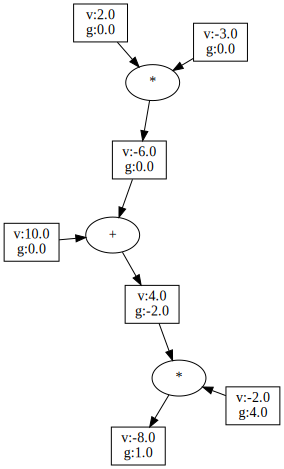

In [42]:
a = value(2.0)
b = value(-3.0)
c = value(10.0)
f = value(-2.0)
e = a * b
d = e + c
L = d * f

L.grad = 1.0
d.grad = f.data
f.grad = d.data
DisplayGraph.display_graph(L)

Let's check if this is true. We will use finite difference to evaluate the gradients we have calculated. Think about is as estimating the gradient numerically.

In [43]:
function short_finite_diff_example()
    # How much does the output change if we change some of the variables by a small amount? 
    h = 0.0001

    a = value(2.0)
    b = value(-3.0)
    c = value(10.0)
    f = value(-2.0)
    e = a * b
    d = e + c
    L = d * f
    L1 = L.data

    a = value(2.0)
    b = value(-3.0)
    c = value(10.0)
    f = value(-2.0) # + h # if we change f by a small amount we expect the "slope" to be d 
    e = a * b
    d = (e + c) + h # if we change d by a small amount we expect the "slope" to be f 
    L = d * f
    L2 = L.data
    slope = (L2 - L1) / h
    return slope
end
@show short_finite_diff_example();

short_finite_diff_example() = -1.9999999999953388


But what about $\frac{d L}{d c}$ and $\frac{d L}{d e}$? How do we calculate these?

### Chain rule
If we want to calculate the derivative of a function $f(x(t),y(t))$ with respect another variable $t$, where $x(t)$ and $y(t)$ depend on $t$ we can use the chain rule:
$$
\frac{d f}{d t} = \frac{\partial f}{\partial x} \frac{d x}{d t} + \frac{\partial f}{\partial y} \frac{d y}{d t}
$$
This can also be written in a more general way:
$$
\frac{\partial f}{\partial t} = \frac{\partial f}{\partial x} \frac{\partial x}{\partial t} + \frac{\partial f}{\partial y} \frac{\partial y}{\partial t}
$$
This form is also valid for functions with more indepedant variables. 

### Applying the Chain rule to the computational graph

Hence, to calculate the gradients for $\frac{d L}{d c}$ and $\frac{d L}{d e}$ we will be using the chain rule: 

$$
\frac{d L}{d c} = \frac{d L}{d d} \frac{d d}{d c}
$$

We already know that $\frac{d L}{d d}=f$. 

For the second term $\frac{d d}{d c}$, we just have to focus on the local part where $d=e+c$. So $\frac{d d}{d c}=1.0$. Hence, we can write:

$$
\frac{d L}{d c} = f \cdot 1.0 = f
$$

Similarly for $\frac{d L}{d e}$ we have to calculate $\frac{d L}{d d} \frac{d d}{d e}$. For $\frac{d d}{d e}=1.0$. Hence, we can write:

$$
\frac{d L}{d e} = f \cdot 1.0 = f
$$

Note that we can actually use the previously calculated gradient of $\frac{d L}{d d}$ to calculate $\frac{d L}{d e}$ and $\frac{d L}{d c}$.

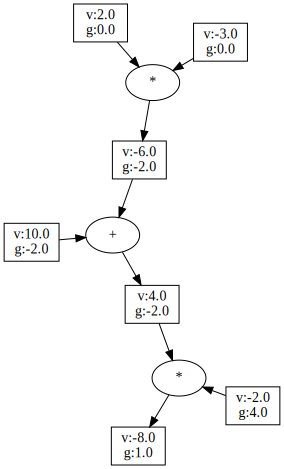

In [44]:
a = value(2.0)
b = value(-3.0)
c = value(10.0)
f = value(-2.0)
e = a * b
d = e + c
L = d * f

L.grad = 1.0
d.grad = f.data
f.grad = d.data
e.grad = d.grad * 1.0
c.grad = d.grad * 1.0
DisplayGraph.display_graph(L)

Lastly, we want to know $\frac{d L}{d a}$ and $\frac{d L}{d b}$. We can use the chain rule again:

$$
\frac{d L}{d a} = \frac{d L}{d d} \frac{d d}{d e} \frac{d e}{d a}
$$

We already know that $\frac{d L}{d d}=f$ and $\frac{d d}{d e}=1.0$. For the last term $\frac{d e}{d a}=b$ since $e=a*b$. Hence, we can write:

$$
\frac{d L}{d a} = f \cdot 1.0 \cdot b = f \cdot b
$$

Similarly for $\frac{d L}{d b}$ we have to calculate $\frac{d L}{d d} \frac{d d}{d e} \frac{d e}{d b}$. For $\frac{d e}{d b}=a$. Hence, we can write:

$$
\frac{d L}{d b} = f \cdot 1.0 \cdot a = f \cdot a
$$

Note that the first part of our calculation resembles the gradient $\frac{d L}{d e} = f \cdot 1.0 = f$ so we can just use the saved gradient in our $e$ object to calculate the gradients for $a$ and $b$. This is the power of the computational graph. If we go backwards we can reuse the gradients we have already calculated.


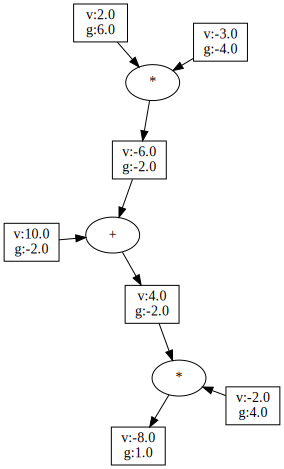

In [45]:
a = value(2.0)
b = value(-3.0)
c = value(10.0)
f = value(-2.0)
e = a * b
d = e + c
L = d * f

L.grad = 1.0
d.grad = f.data
f.grad = d.data
e.grad = d.grad * 1.0
c.grad = d.grad * 1.0
a.grad = e.grad * b.data
b.grad = e.grad * a.data
DisplayGraph.display_graph(L)

We can check this again using the finite difference approach.

In [46]:
function short_finite_diff_example()
    # How much does the output change if we change some of the variables by a small amount? 
    h = 0.0001

    a = value(2.0)
    b = value(-3.0)
    c = value(10.0)
    f = value(-2.0)
    e = a * b
    d = e + c
    L = d * f
    L1 = L.data

    a = value(2.0)  # change a by a small amount
    b = value(-3.0) + h # change b by a small amount
    c = value(10.0)
    f = value(-2.0)
    e = a * b
    d = (e + c)
    L = d * f
    L2 = L.data
    slope = (L2 - L1) / h
    return slope
end
@show short_finite_diff_example();

short_finite_diff_example() = -4.000000000008441


**Summary of Backpropagation:**

This is it we have manually performed backpropagation for our example computational graph. We have calculated the gradients for all variables. We have used the chain rule to calculate the gradients for the variables that are not directly connected to the last variable. We have also seen that we can reuse the gradients we have already calculated.

**Example of Optimization with Gradients:**

Let's look at a simple example of what we can do with the gradients and the computational graph. We can use the gradients to manipulate the variable $L$ with respect to the variables. For example if we want to increase $L$ we can add a little value for each variable in the direction of the gradient. If we want to decrease $L$ we can move in the opposite direction of the gradient.

In [47]:
@show L.data;
a += 0.01 * a.grad
b += 0.01 * b.grad
c += 0.01 * c.grad
f += 0.01 * f.grad
e = a * b
d = e + c
L = d * f
@show L.data;

L.data = -8.0
L.data = -7.286496
